## Analysis - Collections LLM as a Judge

The goal of this notebook is to understand the quality of the collections created through the method "LLM as a judge".  
The analysis to be done are:
- Distribution of values for different samples
- Number of null values

In [9]:
import os
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt

SEEDS = [7270]
PREFIX = "judge_llm"

## Load Collections

In [4]:
collections = []
for seed in SEEDS:
    path = f"../experiments_{seed}/datamodels/collections/train"
    for f in os.listdir(path):
        if f.startswith(PREFIX) and f.endswith(".feather"):
            df = pl.read_ipc(os.path.join(path, f)).with_columns(pl.lit(seed).alias("seed"))
            collections.append(df)

collections_df = pl.concat(collections)

In [5]:
collections_df


collection_idx,test_idx,input,evaluation,seed
i64,i64,"array[i64, 100]",f64,i32
1800,0,"[0, 0, … 0]",0.9,7270
1800,1,"[0, 0, … 0]",0.2,7270
1800,2,"[0, 0, … 0]",0.6,7270
1800,3,"[0, 0, … 0]",0.6,7270
1800,4,"[0, 0, … 0]",0.9,7270
…,…,…,…,…
359,45,"[1, 0, … 0]",0.4,7270
359,46,"[1, 0, … 0]",0.4,7270
359,47,"[1, 0, … 0]",0.4,7270


## Number of Null Values by Test Idx

/tmp/ipykernel_244773/4054992264.py:1: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
  _nulls = collections_df.filter(pl.col("evaluation") == 0).group_by("test_idx").count().sort("test_idx")
/tmp/ipykernel_244773/4054992264.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


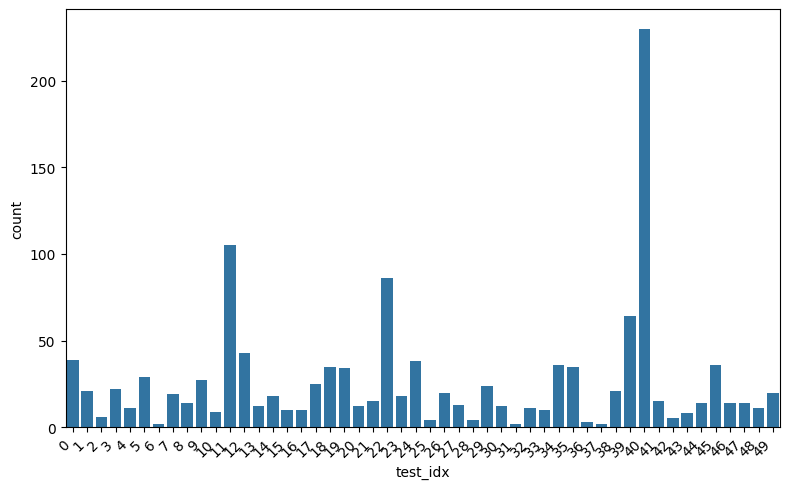

In [12]:
_nulls = collections_df.filter(pl.col("evaluation") == 0).group_by("test_idx").count().sort("test_idx")
plt.figure(figsize=(8, 5))

ax = sns.barplot(
    data=_nulls,
    x="test_idx",
    y="count"
)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout()
plt.show()

## Distributions by Test Idx

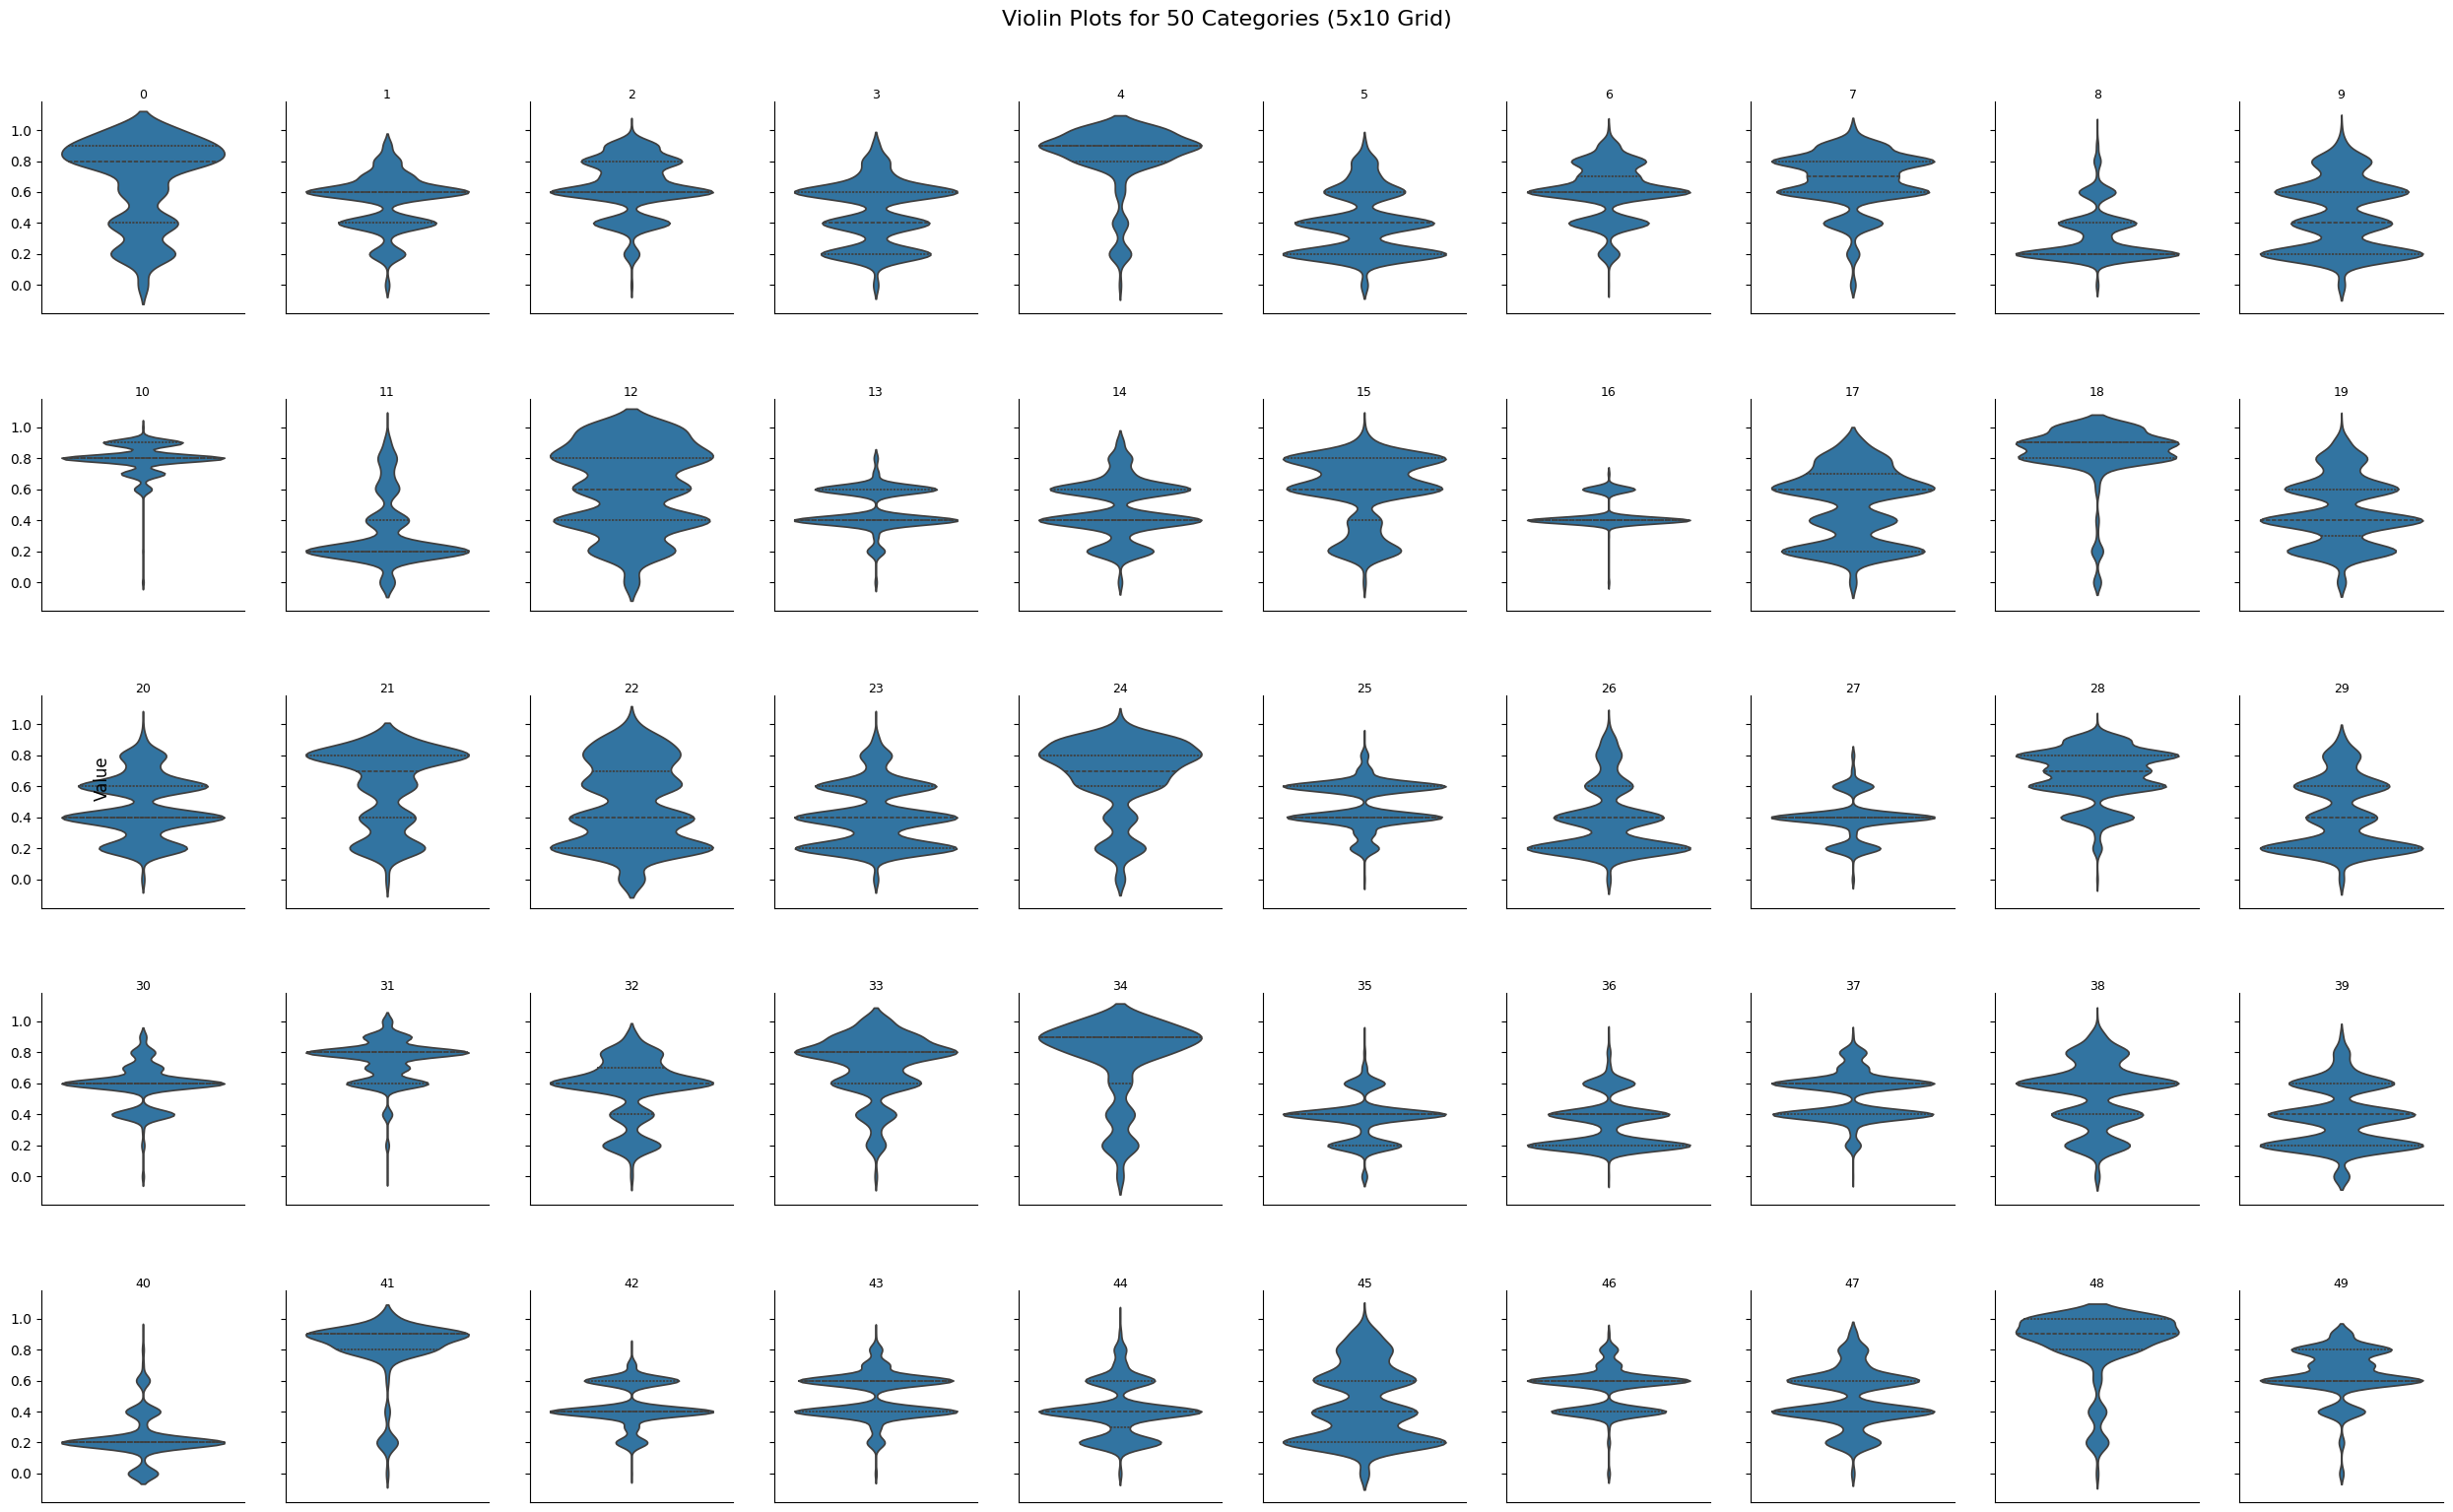

In [27]:
from turtle import width

from numpy import inner


_distribution = collections_df.select(["test_idx", "evaluation"])

n_rows = 5
n_cols = 10
fig, axes = plt.subplots(n_rows, n_cols, figsize=(25, 15), sharey=True)
fig.suptitle('Violin Plots for 50 Categories (5x10 Grid)', y=1.02, fontsize=16)
categories = [str(i) for i in range(50)]

for i, (cat, ax) in enumerate(zip(categories, axes.flatten())):
    cat_data = _distribution.filter(pl.col("test_idx") == int(cat))
    sns.violinplot(
        data=cat_data,
        y="evaluation",
        ax=ax,
        inner="quartile"
    )

    ax.set_title(cat, pad=2, fontsize=9)
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    # Remove spines and ticks for cleaner look
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks([])

# 4. Adjust layout
plt.tight_layout()
plt.subplots_adjust(hspace=0.4, wspace=0.2)  # Adjust spacing between plots

# Add common y-axis label
fig.text(0.04, 0.5, 'Value', va='center', rotation='vertical', fontsize=12)

plt.show()